In [1]:
import pymc3 as pm
import sklearn_ardregression
import numpy as np
import matplotlib.pyplot as plt
from theano import shared
%matplotlib inline
plt.rcParams["font.size"] = 18

In [2]:
# 訓練データ
TRAIN_DATA_SIZE = 100
train_xs, train_ys = sklearn_ardregression.make_dataset(TRAIN_DATA_SIZE) 
train_xs, train_ys = sklearn_ardregression.normalize(train_xs, train_ys) 
train_xs = train_xs.transpose(1, 0)
shared_xs = shared(train_xs)

In [3]:
print(train_xs.shape, train_ys.shape)

(3, 100) (100,)


In [4]:
n_features = train_xs.shape[0]

with pm.Model() as model:
#     alphas = pm.HalfNormal("alphas", sd=1, shape=(n_features,))
#     beta = pm.HalfNormal("beta", sd=1)
    alphas = pm.HalfCauchy("alphas", beta=1, shape=(n_features,))
    beta = pm.HalfCauchy("beta", beta=1)
    
    w = pm.Normal("w", mu=0.0, tau=alphas, shape=(n_features,))
    mu = 0
    for i in range(n_features):
        mu += w[i] * shared_xs[i] 
    z = pm.Normal("z", mu=mu, tau=beta, observed=train_ys)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, beta, alphas]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1244.83draws/s]
/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There 

In [5]:
pm.summary(trace).round(2)

/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.70,0.04,0.00,0.63,0.78,5138.92,1.0
w__1,0.05,0.04,0.00,-0.02,0.13,4981.04,1.0
w__2,0.64,0.04,0.00,0.57,0.72,5190.49,1.0
alphas__0,1.72,1.82,0.03,0.00,5.15,4190.86,1.0
alphas__1,25.95,150.90,3.65,0.00,93.99,1722.26,1.0
alphas__2,1.92,2.31,0.04,0.00,5.93,3676.87,1.0
beta,6.90,0.99,0.02,5.13,8.96,4264.16,1.0


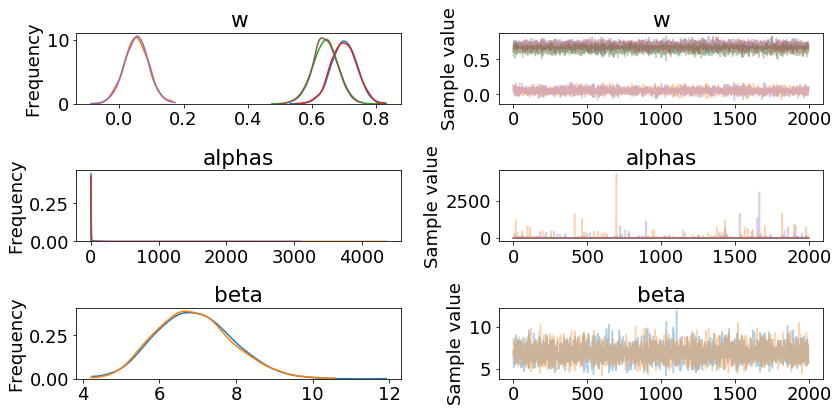

In [6]:
pm.traceplot(trace)
plt.show()

In [7]:
sample_size = trace["w"].shape
print(sample_size)

(4000, 3)


In [8]:
# 重みの事後確率
tw= trace["w"]
print(tw.shape)

(4000, 3)


In [9]:
# 重みの平均値と標準偏差
tw_mean = np.mean(tw, axis=0)
tw_std = np.std(tw, axis=0)
print(tw_mean.shape)
print(tw_std.shape)

(3,)
(3,)


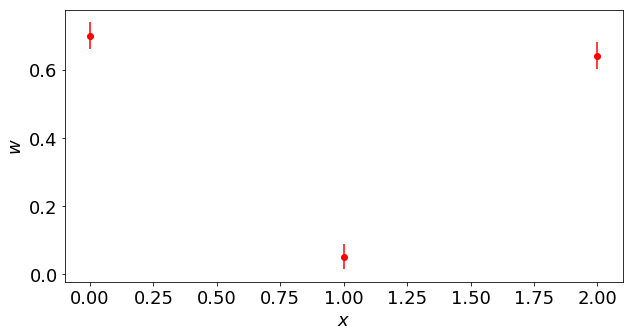

In [10]:
#  期待通り
plt.figure(figsize=(10, 5))
xs = range(tw_std.shape[0])
# plt.scatter(xs, tw_mean, marker="o")

plt.xlabel("$x$")
plt.ylabel("$w$")

plt.errorbar(xs, tw_mean, tw_std, fmt="ro", label="Prediction", marker="o")

plt.show()

In [11]:
for i, (v, s) in enumerate(zip(tw_mean, tw_std)):
    print("[{:0>2}]: {} (σ={})".format(i, v, s))

[00]: 0.6993584297015484 (σ=0.03929935547412315)
[01]: 0.05236912103473608 (σ=0.037872126099774334)
[02]: 0.6411658390125358 (σ=0.03859452004471376)


In [12]:
# p(z|D)　事後予測確率
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)

100%|██████████| 1000/1000 [00:00<00:00, 1685.68it/s]


In [13]:
ppc_z = ppc["z"]
ppc_z.shape

(1000, 100)

In [14]:
# 平均値と標準偏差
ppc_z_mean = np.mean(ppc_z, axis=0)
ppc_z_std = np.std(ppc_z, axis=0)
print(ppc_z_mean.shape)
print(ppc_z_std.shape)

(100,)
(100,)


In [15]:
# 誤差の絶対値の平均値と標準偏差
abs_errors = np.abs(train_ys- ppc_z_mean)
mean_abs_errors = np.mean(abs_errors)
std_abs_errors = np.std(abs_errors)
print("差分の絶対値の平均値: {}".format(mean_abs_errors))
print("差分の絶対値の標準偏差: {}".format(std_abs_errors))

差分の絶対値の平均値: 0.29147289786808755
差分の絶対値の標準偏差: 0.22963431608325635


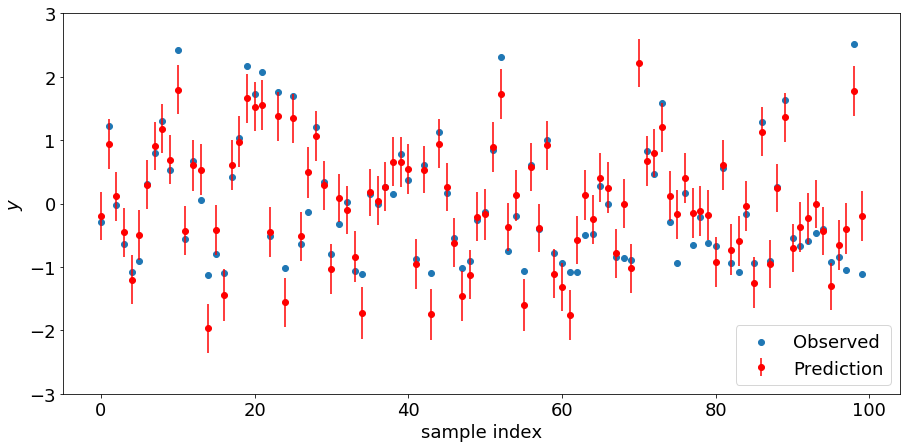

In [16]:
# 訓練データの一致度合いを見る。

plt.figure(figsize=(15, 7))
xs = range(ppc_z_mean.shape[0])
plt.scatter(xs, train_ys, marker="o", label="Observed")
# plt.plot(xs, ppc_z_mean, marker="o", label="Prediction")

plt.xlabel("sample index")
plt.ylabel("$y$")
plt.ylim(-3, 3)
plt.errorbar(xs, ppc_z_mean, ppc_z_std, fmt="ro", label="Prediction", marker="o")
plt.legend(loc="best")
plt.show()

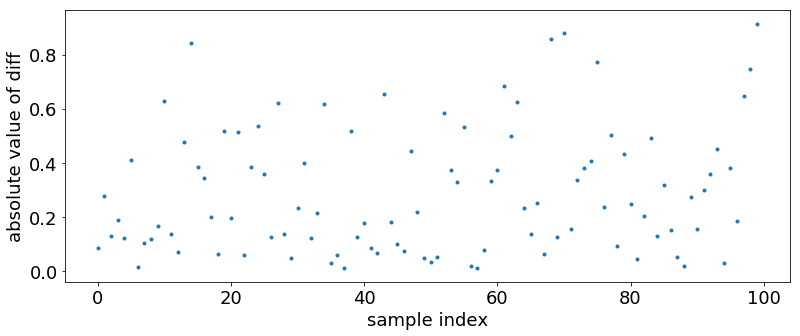

In [17]:
# 差の絶対値

plt.figure(figsize=(13, 5))
size = abs_errors.shape[0]
xs = list(range(size))
plt.scatter(xs, abs_errors, marker=".")
plt.xlabel("sample index")
plt.ylabel("absolute value of diff")
plt.show()

In [18]:
# テストデータ
TEST_DATA_SIZE = 30
test_xs, test_ys = sklearn_ardregression.make_dataset(TEST_DATA_SIZE) 
test_xs, test_ys = sklearn_ardregression.normalize(test_xs, test_ys) 
test_xs = test_xs.transpose(1, 0)
print(test_xs.shape)

(3, 30)


In [19]:
# https://docs.pymc.io/notebooks/posterior_predictive.html
shared_xs.set_value(test_xs)

In [20]:
ppc = pm.sample_posterior_predictive(trace, model=model, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1356.39it/s]


In [21]:
ppc_z = ppc["z"]
print(ppc_z.shape)

(1000, 30)


In [22]:
# 平均値と標準偏差
ppc_z_mean = np.mean(ppc_z, axis=0)
ppc_z_std = np.std(ppc_z, axis=0)
print(ppc_z_mean.shape)
print(ppc_z_std.shape)

(30,)
(30,)


In [23]:
# 誤差の絶対値の平均値と標準偏差

abs_errors = np.abs(test_ys- ppc_z_mean)
mean_abs_errors = np.mean(abs_errors)
std_abs_errors = np.std(abs_errors)
print("差分の絶対値の平均値: {}".format(mean_abs_errors))
print("差分の絶対値の標準偏差: {}".format(std_abs_errors))

差分の絶対値の平均値: 0.2982937564912423
差分の絶対値の標準偏差: 0.27419755045762073


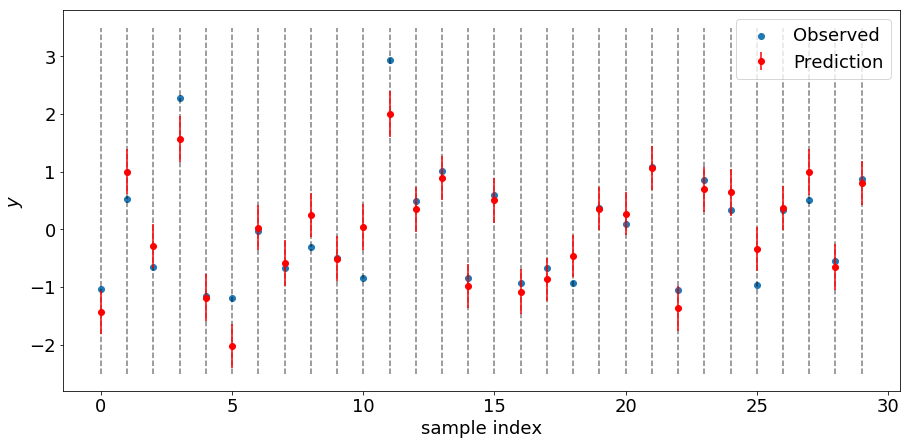

In [24]:
# テストデータの一致度合いを見る。

plt.figure(figsize=(15, 7))
xs = range(ppc_z_mean.shape[0])
plt.scatter(xs, test_ys, marker="o", label="Observed")

plt.xlabel("sample index")
plt.ylabel("$y$")
plt.vlines(list(range(TEST_DATA_SIZE)), ymin=-2.5, ymax=3.5, linestyle="dashed", alpha=0.5)
plt.errorbar(xs, ppc_z_mean, ppc_z_std, fmt="ro", label="Prediction", marker="o")
plt.legend(loc="best")
plt.show()

In [25]:
# 差の絶対値の平均値と標準偏差

abs_errors = np.abs(test_ys - ppc_z_mean)
mean_abs_errors = np.mean(abs_errors)
std_abs_errors = np.std(abs_errors)
print("差分の絶対値の平均値: {}".format(mean_abs_errors))
print("差分の絶対値の標準偏差: {}".format(std_abs_errors))

差分の絶対値の平均値: 0.2982937564912423
差分の絶対値の標準偏差: 0.27419755045762073


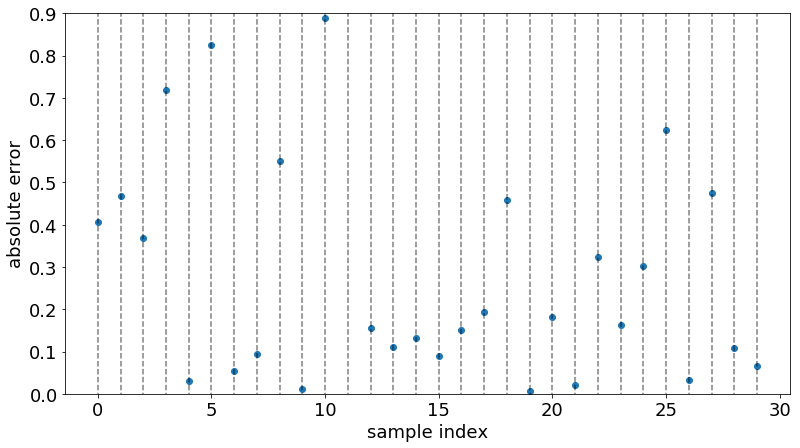

In [26]:
plt.figure(figsize=(13, 7))
size = abs_errors.shape[0]
xs = list(range(size))
plt.scatter(xs, abs_errors, marker="o")
plt.vlines(list(range(TEST_DATA_SIZE)), ymin=-0.5, ymax=0.9, linestyle="dashed", alpha=0.5)
plt.ylim(0, 0.9)
plt.xlabel("sample index")
plt.ylabel("absolute error")
plt.show()